# FSRS4RemNote Optimizer

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4remnote/main/optimizer.ipynb)

↑ Click the above button to open the optimizer on Google Colab.

> If you can't see the button and are located in the Chinese Mainland, please use a proxy or VPN.

You can export your review data with FSRS4RemNote Plugin. If you have installed [FSRS4RemNote](https://remnote.com/plugins/fsrs4remnote) (version >= 0.2.0), you can find the command named `Create Revlog CSV` via `Ctrl` `/`. Please click it and wait for the download of `remnote-revlog.csv`.

Upload your `remnote-revlog.csv` file on the `Left sidebar -> Files`, drag and drop your file in the current directory (not the `sample_data` directory). 

Then set the `timezone` and `next_day_starts_at`.

After that, just run all (`Runtime -> Run all` or `Ctrl + F9`) and wait for minutes. You can see the optimal parameters in section **2.3 Result**.

**NOTE**: The default output is generated from my review logs. If you find the output is the same as mine, maybe your notebook hasn't run there.

In [1]:
# Replace it with your timezone. I'm in China, so I use Asia/Shanghai.
# You can find your timezone here: https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
timezone = "Asia/Shanghai"

# The time when the next day starts. For example, if the next day starts at 4:00 AM, then
next_day_starts_at = 4

## 1 Build dataset

### 1.1 Create time-series feature & analysis

The following code cell will extract the review logs from your Anki collection and preprocess them to a trainset which is saved in [./revlog_history.tsv](./revlog_history.tsv).

The time-series features are important in optimizing the model's parameters. For more detail, please see my paper: https://www.maimemo.com/paper/

Then it will generate a concise analysis for your review logs. 

- The `r_history` is the history of ratings on each review. `3,3,3,1` means that you press `Good, Good, Good, Again`. It only contains the first rating for each card on the review date, i.e., when you press `Again` in review and  `Good` in relearning steps 10min later, only `Again` will be recorded.
- The `avg_interval` is the actual average interval after you rate your cards as the `r_history`. It could be longer than the interval given by Anki's built-in scheduler because you reviewed some overdue cards.
- The `avg_retention` is the average retention after you press as the `r_history`. `Again` counts as failed recall, and `Hard, Good and Easy` count as successful recall. Retention is the percentage of your successful recall.
- The `stability` is the estimated memory state variable, which is an approximate interval that leads to 90% retention.
- The `factor` is `stability / previous stability`.
- The `group_cnt` is the number of review logs that have the same `r_history`.

In [2]:
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
from itertools import accumulate
from tqdm.auto import tqdm

tqdm.pandas()

df = pd.read_csv("./remnote-revlog.csv")
df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000) &
        (df['r'] > 0)].copy()
df['create_date'] = pd.to_datetime(df['cid'] // 1000, unit='s')
df['create_date'] = df['create_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df['review_date'] = pd.to_datetime(df['id'] // 1000, unit='s')
df['review_date'] = df['review_date'].dt.tz_localize('UTC').dt.tz_convert(timezone)
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)
type_sequence = np.array(df['type'])
time_sequence = np.array(df['time'])
df.to_csv("revlog.csv", index=False)
print("revlog.csv saved.")

df['real_days'] = df['review_date'] - timedelta(hours=int(next_day_starts_at))
df['real_days'] = pd.DatetimeIndex(df['real_days'].dt.floor('D', ambiguous='infer', nonexistent='shift_forward')).to_julian_date()
df.drop_duplicates(['cid', 'real_days'], keep='first', inplace=True)
df['delta_t'] = df.real_days.diff()
df.dropna(inplace=True)
df['i'] = df.groupby('cid').cumcount() + 1
df.loc[df['i'] == 1, 'delta_t'] = 0

df = df.groupby('cid').filter(lambda group: group['type'].iloc[0] == 0)
df['prev_type'] = df.groupby('cid')['type'].shift(1).fillna(0).astype(int)
df['helper'] = ((df['type'] == 0) & ((df['prev_type'] == 1) | (df['prev_type'] == 2)) & (df['i'] > 1)).astype(int)
df['helper'] = df.groupby('cid')['helper'].cumsum()
df = df[df['helper'] == 0]
del df['prev_type']
del df['helper']

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('cid', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('cid', group_keys=False)['r'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]
df['y'] = df['r'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])

def remove_outliers(sub_df):
    Q1 = sub_df['delta_t'].quantile(0.25)
    Q3 = sub_df['delta_t'].quantile(0.75)
    IQR = Q3 - Q1 + 1
    return sub_df[(sub_df['delta_t'] >= Q1 - 1.5 * IQR) & (sub_df['delta_t'] <= Q3 + 1.5 * IQR)]

df = df.groupby(['r_history', 't_history'], as_index=False, group_keys=False).progress_apply(remove_outliers)

def remove_non_continuous_rows(group):
    discontinuity = group['i'].diff().fillna(1).ne(1)
    if not discontinuity.any():
        return group
    else:
        first_non_continuous_index = discontinuity.idxmax()
        return group.loc[:first_non_continuous_index-1]

df = df.groupby('cid', as_index=False, group_keys=False).progress_apply(remove_non_continuous_rows)

df.to_csv('revlog_history.tsv', sep="\t", index=False)
print("Trainset saved.")

df['retention'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['y'].transform('mean')
df['total_cnt'] = df.groupby(by=['r_history', 'delta_t'], group_keys=False)['id'].transform('count')
print("Retention calculated.")

df = df.drop(columns=['id', 'cid', 'time', 'type', 'create_date', 'review_date', 'real_days', 'r', 't_history', 'y'])
df.drop_duplicates(inplace=True)
df['retention'] = df['retention'].map(lambda x: max(min(0.99, x), 0.01))

def cal_stability(group: pd.DataFrame) -> pd.DataFrame:
    group_cnt = sum(group['total_cnt'])
    if group_cnt < 10:
        return pd.DataFrame()
    group['group_cnt'] = group_cnt
    if group['i'].values[0] > 1:
        r_ivl_cnt = sum(group['delta_t'] * group['retention'].map(np.log) * pow(group['total_cnt'], 2))
        ivl_ivl_cnt = sum(group['delta_t'].map(lambda x: x ** 2) * pow(group['total_cnt'], 2))
        group['stability'] = round(np.log(0.9) / (r_ivl_cnt / ivl_ivl_cnt), 1)
    else:
        group['stability'] = 0.0
    group['avg_retention'] = round(sum(group['retention'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 3)
    group['avg_interval'] = round(sum(group['delta_t'] * pow(group['total_cnt'], 2)) / sum(pow(group['total_cnt'], 2)), 1)
    del group['total_cnt']
    del group['retention']
    del group['delta_t']
    return group

df = df.groupby(by=['r_history'], group_keys=False).progress_apply(cal_stability)
print("Stability calculated.")
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace=True)
df.sort_values(by=['r_history'], inplace=True, ignore_index=True)

if df.shape[0] > 0:
    for idx in tqdm(df.index, desc="analysis"):
        item = df.loc[idx]
        index = df[(df['i'] == item['i'] + 1) & (df['r_history'].str.startswith(item['r_history']))].index
        df.loc[index, 'last_stability'] = item['stability']
    df['factor'] = round(df['stability'] / df['last_stability'], 2)
    df = df[(df['i'] >= 2) & (df['group_cnt'] >= 50)].copy()
    df['last_recall'] = df['r_history'].map(lambda x: x[-1])
    df = df[df.groupby(['i', 'r_history'], group_keys=False)['group_cnt'].transform(max) == df['group_cnt']]
    df.to_csv('./stability_for_analysis.tsv', sep='\t', index=None)
    print("Analysis saved!")
    caption = "1:again, 2:hard, 3:good, 4:easy\n"
    analysis = df[df['r_history'].str.contains(r'^[1-4][^124]*$', regex=True)][['r_history', 'avg_interval', 'avg_retention', 'stability', 'factor', 'group_cnt']].to_string(index=False)
    print(caption + analysis)

revlog.csv saved.


  0%|          | 0/214 [00:00<?, ?it/s]

  0%|          | 0/636 [00:00<?, ?it/s]

Trainset saved.
Retention calculated.


  0%|          | 0/106 [00:00<?, ?it/s]

Stability calculated.


analysis:   0%|          | 0/15 [00:00<?, ?it/s]

Analysis saved!
1:again, 2:hard, 3:good, 4:easy
r_history  avg_interval  avg_retention  stability  factor  group_cnt
        3           1.0          0.977        4.5     inf        323
      3,3           3.0          0.989       28.8    6.40        185
    3,3,3           7.1          0.990       74.7    2.59        134
        4           1.1          0.953        3.2     inf         92


## 2 Optimize parameter

### 2.1 Define the model

FSRS is a time-series model for predicting memory states.

In [3]:
%pip -q install fsrs4anki_optimizer==3.25.3
import fsrs4anki_optimizer as optimizer

optimizer = optimizer.Optimizer()

"""
w[0]: initial_stability_for_again_answer
w[1]: initial_stability_step_per_rating
w[2]: initial_difficulty_for_good_answer
w[3]: initial_difficulty_step_per_rating
w[4]: next_difficulty_step_per_rating
w[5]: next_difficulty_reversion_to_mean_speed (used to avoid ease hell)
w[6]: next_stability_factor_after_success
w[7]: next_stability_stabilization_decay_after_success
w[8]: next_stability_retrievability_gain_after_success
w[9]: next_stability_factor_after_failure
w[10]: next_stability_difficulty_decay_after_success
w[11]: next_stability_stability_gain_after_failure
w[12]: next_stability_retrievability_gain_after_failure
For more details about the parameters, please see: 
https://github.com/open-spaced-repetition/fsrs4anki/wiki/Free-Spaced-Repetition-Scheduler
"""
optimizer.define_model()
print(optimizer.init_w)

Note: you may need to restart the kernel to use updated packages.
[1, 1, 5, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2, -0.2, 0.2, 1]


### 2.2 Train the model

The [./revlog_history.tsv](./revlog_history.tsv) generated before will be used for training the FSRS model.

  0%|          | 0/1155 [00:00<?, ?it/s]

Tensorized!
TRAIN: 663 TEST: 492
dataset built
Loss in trainset: 0.2095
Loss in testset: 0.1172


pre-train:   0%|          | 0/498 [00:00<?, ?it/s]

w: [1.1191, 1.0128, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/1491 [00:00<?, ?it/s]

Loss in trainset: 0.2070
Loss in testset: 0.1165
iteration: 512
w: [1.1513, 0.9954, 4.9768, -0.4768, -0.4768, 0.2232, 1.4232, -0.1768, 0.8232, 2.0232, -0.1768, 0.2232, 1.0232]
Loss in trainset: 0.2012
Loss in testset: 0.1155
iteration: 1009
w: [1.1718, 0.9843, 4.9548, -0.4549, -0.4548, 0.2451, 1.4452, -0.1548, 0.8452, 2.0452, -0.1548, 0.2452, 1.0451]
Loss in trainset: 0.1959
Loss in testset: 0.1145
iteration: 1506
w: [1.1777, 0.9811, 4.9466, -0.4469, -0.4467, 0.2531, 1.4534, -0.15, 0.8533, 2.0533, -0.1467, 0.2533, 1.0532]
Loss in trainset: 0.1943
Loss in testset: 0.1142
TRAIN: 803 TEST: 352
dataset built
Loss in trainset: 0.1805
Loss in testset: 0.1468


pre-train:   0%|          | 0/1245 [00:00<?, ?it/s]

w: [1.119, 1.1189, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/1164 [00:00<?, ?it/s]

Loss in trainset: 0.1764
Loss in testset: 0.1441
iteration: 512
w: [1.1512, 1.151, 4.9768, -0.4768, -0.4768, 0.2232, 1.4232, -0.1768, 0.8232, 2.0232, -0.1768, 0.2232, 1.0232]
Loss in trainset: 0.1713
Loss in testset: 0.1409
iteration: 900
w: [1.1715, 1.1714, 4.9548, -0.4549, -0.4548, 0.2451, 1.4452, -0.1548, 0.8452, 2.0452, -0.1548, 0.2452, 1.0451]
Loss in trainset: 0.1671
Loss in testset: 0.1384
iteration: 1288
w: [1.1774, 1.1772, 4.9467, -0.4468, -0.4467, 0.2531, 1.4533, -0.15, 0.8533, 2.0533, -0.1467, 0.2533, 1.0532]
Loss in trainset: 0.1658
Loss in testset: 0.1376
TRAIN: 844 TEST: 311
dataset built
Loss in trainset: 0.1296
Loss in testset: 0.2805


pre-train:   0%|          | 0/1191 [00:00<?, ?it/s]

w: [1.1192, 1.1189, 5.0, -0.5, -0.5, 0.2, 1.4, -0.2, 0.8, 2.0, -0.2, 0.2, 1.0]


train:   0%|          | 0/1341 [00:00<?, ?it/s]

Loss in trainset: 0.1275
Loss in testset: 0.2724
iteration: 512
w: [1.1514, 1.151, 4.9768, -0.4768, -0.5232, 0.2232, 1.4232, -0.1768, 0.8232, 2.0232, -0.1768, 0.2232, 1.0232]
Loss in trainset: 0.1254
Loss in testset: 0.2618
iteration: 959
w: [1.1719, 1.1713, 4.9548, -0.4549, -0.5452, 0.2444, 1.4452, -0.1548, 0.8451, 2.0452, -0.1548, 0.2452, 1.0451]
Loss in trainset: 0.1237
Loss in testset: 0.2528
iteration: 1406
w: [1.1777, 1.1772, 4.9467, -0.4468, -0.5533, 0.2517, 1.4533, -0.15, 0.8532, 2.0533, -0.1467, 0.2533, 1.0532]
Loss in trainset: 0.1232
Loss in testset: 0.2501

Training finished!


[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

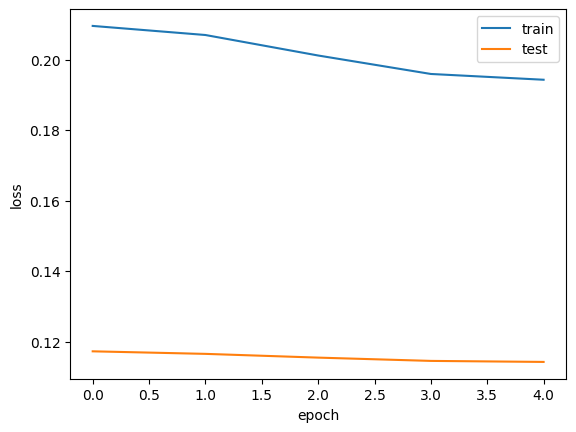

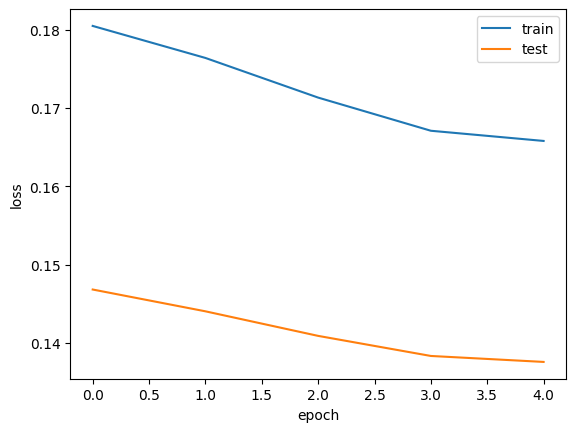

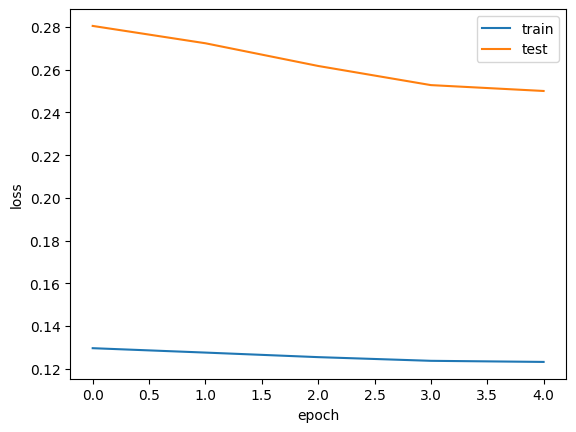

In [4]:
optimizer.train()

### 2.3 Result

Copy the optimal parameters for FSRS for you in the output of next code cell after running.

In [5]:
print(optimizer.w)

[1.1776, 1.1118, 4.9467, -0.4468, -0.4822, 0.2526, 1.4533, -0.15, 0.8533, 2.0533, -0.1467, 0.2533, 1.0532]


### 2.4 Preview

You can see the memory states and intervals generated by FSRS as if you press the good in each review at the due date scheduled by FSRS.

In [6]:
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9

preview = optimizer.preview(requestRetention)
print(preview)

1:again, 2:hard, 3:good, 4:easy

first rating: 1
rating history: 1,3,3,3,3,3,3,3,3,3,3
interval history: 0d,1d,3d,9d,23d,1.8m,4.0m,8.4m,1.4y,2.6y,4.7y
difficulty history: 0,5.8,5.6,5.4,5.3,5.2,5.2,5.1,5.1,5.0,5.0

first rating: 2
rating history: 2,3,3,3,3,3,3,3,3,3,3
interval history: 0d,2d,6d,16d,1.3m,3.1m,6.6m,1.1y,2.1y,3.9y,6.9y
difficulty history: 0,5.4,5.3,5.2,5.1,5.1,5.1,5.0,5.0,5.0,5.0

first rating: 3
rating history: 3,3,3,3,3,3,3,3,3,3,3
interval history: 0d,3d,9d,24d,1.9m,4.4m,9.2m,1.5y,2.9y,5.2y,9.0y
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9,4.9

first rating: 4
rating history: 4,3,3,3,3,3,3,3,3,3,3
interval history: 0d,5d,14d,1.2m,2.9m,6.5m,1.1y,2.1y,4.0y,7.1y,12.1y
difficulty history: 0,4.5,4.6,4.7,4.8,4.8,4.8,4.9,4.9,4.9,4.9



You can change the `test_rating_sequence` to see the scheduling intervals in different ratings.

In [7]:
test_rating_sequence = "3,3,3,3,3,1,1,3,3,3,3,3"
requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
easyBonus = 1.3
hardInterval = 1.2

preview_sequence = optimizer.preview_sequence(test_rating_sequence, requestRetention, easyBonus, hardInterval)
print(preview_sequence)

tensor([3.4012, 4.9467])
tensor([9.1666, 4.9467])
tensor([24.0572,  4.9467])
tensor([58.4091,  4.9467])
tensor([131.0872,   4.9467])
tensor([6.0816, 5.6675])
tensor([2.7536, 6.2062])
tensor([7.7680, 5.8881])
tensor([19.7536,  5.6503])
tensor([46.6734,  5.4725])
tensor([103.6197,   5.3397])
tensor([217.3855,   5.2404])
rating history: 3,3,3,3,3,1,1,3,3,3,3,3
interval history: 0,3,9,24,58,131,6,3,8,20,47,104,217
difficulty history: 0,4.9,4.9,4.9,4.9,4.9,5.7,6.2,5.9,5.7,5.5,5.3,5.2


### 2.5 Predict memory states and distribution of difficulty

Predict memory states for each review group and save them in [./prediction.tsv](./prediction.tsv).

Meanwhile, it will count the distribution of difficulty.

In [8]:
optimizer.predict_memory_states()

prediction.tsv saved.


difficulty
4    0.144589
5    0.792208
6    0.063203
Name: count, dtype: float64

## 3 Evaluate the model

### 3.1 Loss

Evaluate the model with the log loss. It will compare the log loss between initial model and trained model.

And it will predict the stability, difficulty and retrievability for each revlog in [./evaluation.tsv](./evaluation.tsv).

In [9]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss before training: {loss_before:.4f}")
print(f"Loss after training: {loss_after:.4f}")

Loss before training: 0.1702
Loss after training: 0.1582


### 3.2 Calibration graph

1. FSRS predicts the stability and retention for each review.
2. Reviews are grouped into 40 bins according to their predicted retention.
3. Count the true retention of each bin.
4. Plot (predicted retention, true retention) in the line graph.
5. Plot (predicted retention, size of bin) in the bar graph.
6. Combine these graphs to create the calibration graph.

Ideally, the blue line should be aligned with the orange one. If the blue line is higher than the orange line, the FSRS underestimates the retention. When the size of reviews within a bin is small, actual retention may deviate largely, which is normal.

R-squared (aka the coefficient of determination), is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). The higher the R-squared, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Coefficient_of_determination

RMSE (root mean squared error) is the square root of the average of squared differences between prediction and actual observation. The lower the RMSE, the better the model fits your data. For details, please see https://en.wikipedia.org/wiki/Root-mean-square_deviation

R-squared: -4.2014
RMSE: 0.0694
[0.84092738 0.14468798]


(<Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 2 Axes>)

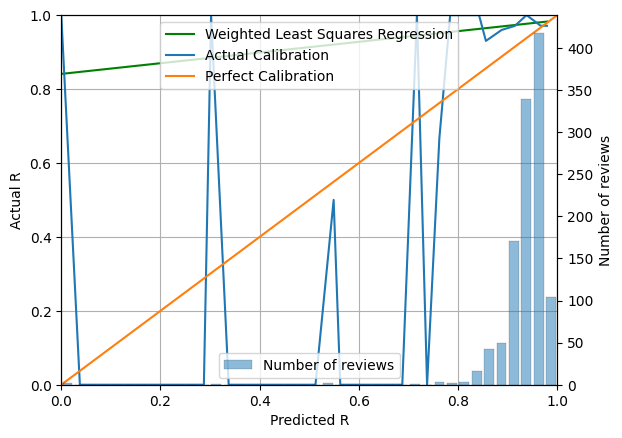

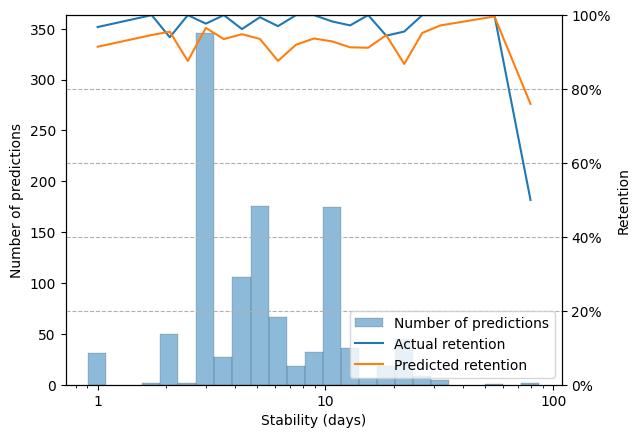

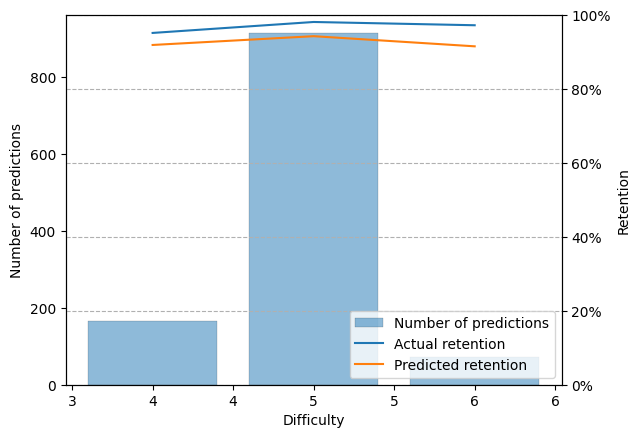

In [10]:
optimizer.calibration_graph()

### 3.3 Cumulative B-W Metric

For details about Cumulative B-W Metric, please see: [Algorithm SM-17 as a good predictor - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithm_SM-17_as_a_good_predictor)

In [11]:
optimizer.bw_matrix()

d_bin,4,5
s_bin,,
2.740000,,-1.14%
3.840000,-0.08%,-6.28%
10.540000,,-5.40%
20.660000,,-8.28%


### 3.4 Compare with SM-2

For details about universal metric, please see: [Algorithmic contest: SuperMemo 2 vs. SuperMemo 17 - supermemo.guru](https://supermemo.guru/wiki/Universal_metric_for_cross-comparison_of_spaced_repetition_algorithms#Algorithmic_contest:_SuperMemo_2_vs._SuperMemo_17)

Loss of SM-2: 0.1767
R-squared: -4.5871
RMSE: 0.1162
[0.84879963 0.14180188]
Universal Metric of FSRS: 0.0581
Universal Metric of SM2: 0.0900


(<Figure size 640x480 with 2 Axes>, <Figure size 600x600 with 1 Axes>)

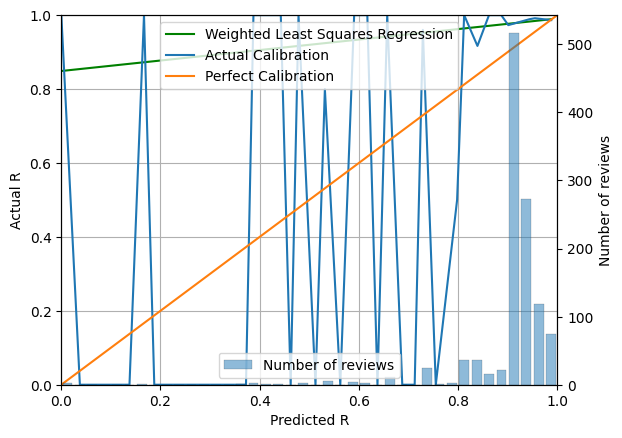

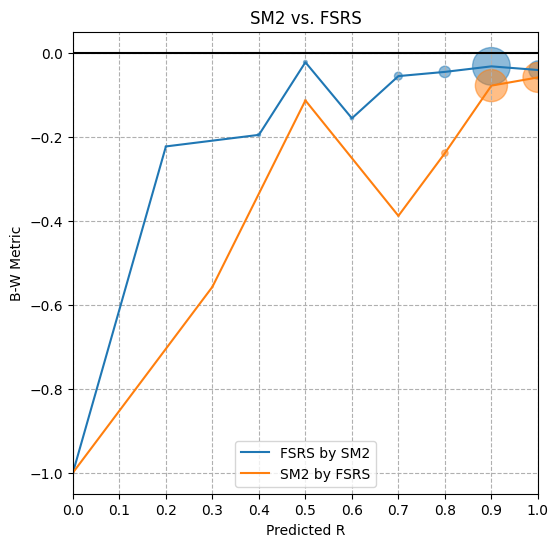

In [12]:
optimizer.compare_with_sm2()